# FINAL PROJECT

In the final project, you will create a closed loop system for an SBML model.
Start by selecting a model from the [BioModels Curated branch](https://www.ebi.ac.uk/biomodels/search?query=*%3A*+AND+curationstatus%3A%22Manually+curated%22&domain=biomodels).)
You don't have to restrict yourself to thoses models, but you'll find that the curated BioModels are fairly easy to reproduce.) You'll find a paper associated with each model.

1. **Specify the requirements for the control system.** (10 pt) After reading the paper for the model, propose a chemical species for the control output
and an operating point for it. You should also indicate the desired
operating characteristics such as settling time and overshoot.
Justify this in terms of the potential value of controlling
the chemical species and why the particular operating point makes sense.
1. **Determine the control input you will use**. (10 pt) This will require evaluating the DC gain of
of candidate control inputs on chemical species that are the control outputs.
1. **Design the control system**. (15 pt) You will specify a controller and possibly a filter.
You will select the parameters of the elements based on the poles and DC gains implied by
the operating characteristics in (1).
1. **Evaluate your design.** (25 pt) You will construct a simulation testbed in which the
SBML model is regulated by your control architecture.
You should evaluate the effects of disturbances and noise.
1. **Discuss trade-offs.** (10 pt) Discuss trade-offs in the selection of parameter values in your design.
This should consider the impact of parameter values on the closed loop transfer functions.

You will receive 5 extra points if you use LaTex for your mathematical analyses.

**All students will present their projects during the last week of class.**
This is an ungraded presentation intended to give you early feedback on your work.

# Preliminaries

In [1]:
!pip install -q controlSBML
!pip install -q control
import control
import controlSBML as ctl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
from controlSBML.util import makeSimulationTimes

     |████████████████████████████████| 398 kB 33.0 MB/s 
     |████████████████████████████████| 8.8 MB 44.1 MB/s 
     |████████████████████████████████| 154 kB 44.5 MB/s 
     |████████████████████████████████| 485 kB 17.9 MB/s 
     |████████████████████████████████| 6.8 MB 28.7 MB/s 
     |████████████████████████████████| 121 kB 47.8 MB/s 
     |████████████████████████████████| 342 kB 16.2 MB/s 
     |████████████████████████████████| 428 kB 47.6 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 80 kB 7.6 MB/s 
     |████████████████████████████████| 561 kB 43.4 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 130 kB 38.8 MB/s 
     |████████████████████████████████| 133 kB 66.4 MB/s 
     |████████████████████████████████| 106 kB 75.2 MB/s 
     |████████████████████████████████| 250 kB 69.8 MB/s 
     |████████████████████████████████| 103 kB 61.8 MB/s 
     |██████████████

# Helpful Hints

## LaTex Basics

1. All LaTex appears between dollar signs (``$``)
1. Subscripts: $x_2$
1. Superscript: $x^2$
1. Summation: $\sum_{n=0}^{\infty} e^{nt}$
1. Derivatives: $\dot{x}(t)$
1. Bold: ${\bf A}$
1. Fractions: $\frac{a}{b}$

## Closed Loop Transfer Functions

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

# 1. Specify Requirements

**Tellurium simulation with Heat-shock Condition**

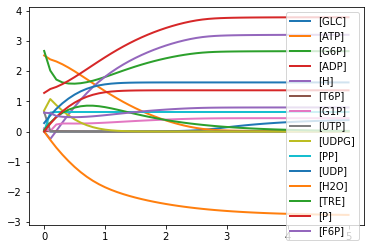

In [2]:
# GLC = glucose 
# ATP = adenosine triphosphate
# ADP = Adenosine diphosphate
# H = hydrogen ion
# UDPG = UDP-glucose
# PP = pyrophosphate/diphosphate
# P = phosphate
# TRE = tetrahalose
# G6P = glucose-6-phosphate
# G1P = glucose-1-phosphate
# UTP = uridine triphosphate
# UDP = uridine diphosphate
# T6P = tetrahalose-6-phosphate
# F6P = fructose-6-phosphate
# H20 = water

## Reaction order
# Hexokinase
# Phosphoglucomutase
# UDP–glucose phosphorylase
# T6P synthase
# T6P phosphatase
# Trehalase
# G6P isomerase

tetrahalose_MODEL = """
J1: GLC + ATP -> G6P + ADP + H; shock1*Vmax1*((1/(KGLC1*KATP1))*(GLC*ATP-(G6P*ADP/Keq1)))/((1+GLC/KGLC1+G6P/KG6P1+T6P/KT6P5)*(1+ATP/KATP1+ADP/KADP1))
J2: G6P -> G1P; shock2*Vmax2*((1/KG6P2)*(G6P-G1P/Keq2))/(1+G6P/KG6P2+G1P/KG1P2)
J3: G1P + UTP + H -> UDPG + PP; shock3*Vmax3*((UTP/KUTP3)*(G1P/KG1P3))/(KiUTP3/KUTP3+UTP/KUTP3+G1P/KG1P3+(UTP*G1P/KUTP3*KG1P3)+(KiUTP3*UDPG/KUTP3*KiUDPG3)+(G1P*UDPG/KG1P3*KiUDPG3))
J4: G6P + UDPG -> T6P + UDP + H; shock4*Vmax4*(G6P*UDPG/KG6P4*KUDPG4)/((1+G6P/KG6P4)*(1+UDPG/KUDPG4))
J5: T6P + H2O -> TRE + P; shock5*Vmax5*(T6P/KT6P5)/(1+T6P/KT6P5)
J6: TRE + H2O -> GLC + GLC; shock6*Vmax6*(TRE/KTRE6)/(1+TRE/KTRE6)
J7: G6P -> F6P; shock7*Vmax7/KG6P7*(G6P-F6P/Keq7)/(1+G6P/KG6P7+F6P/KF6P7) 



KGLC1 = 0.08
KATP1 = 0.15
KG6P1 = 30
KADP1 = 0.23
KiTRH1 = 0.04
Keq1 = 2000
Vmax1 = 350
shock1 = 8

KG6P2 = 0.05
KG1P2 = 0.023
Keq2 = 1/6
Vmax2 = 0.3545
shock2 = 16 

KUTP3 = 0.11
KiUTP3 = 0.11
KG1P3 = 0.32
KiUDPG3 = 0.035
Vmax3 = 36.82
shock3 = 16

KG6P4 = 3.8
KUDPG4 = 0.886
Vmax4 = 1.371
shock4 = 12

KT6P5 = 0.5
Vmax5 = 6.5
shock5 = 18

KTRE6 = 2.99
Vmax6 = 0.5
shock6 = 6

Keq7 = 0.3  
KF6P7 = 0.29 
KG6P7 = 1.4
Vmax7 = 1071.0
shock7 = 1


ADP = 1.282
ATP = 2.525
F6P = 0.625
GLC = 0.09675
G1P = 0.1
G6P = 2.675
TRE = 0.05
T6P = 0.02
UDP = 0.2815
UDPG = 0.7
UTP = 0.6491




"""
tetrahalose_MODEL_RR = te.loada(tetrahalose_MODEL)
tetrahalose_MODEL_DATA = tetrahalose_MODEL_RR.simulate()
# plt.plot(tetrahalose_MODEL_DATA)
# plt.ylim([0,10])
# plt.legend()
tetrahalose_MODEL_RR.plot(tetrahalose_MODEL_DATA)

**Tellurium Simulation with Bulk Glucose Transport and No Heat-shock Condition**

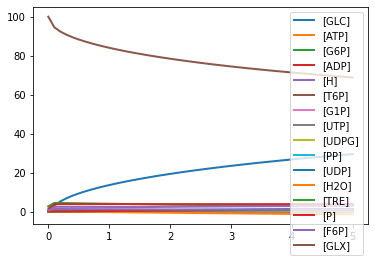

In [3]:
# GLC = glucose (intracellular)
# GLX = glucose (bulk media)
# ATP = adenosine triphosphate
# ADP = Adenosine diphosphate
# H = hydrogen ion
# UDPG = UDP-glucose
# PP = pyrophosphate/diphosphate
# P = phosphate
# TRE = tetrahalose
# G6P = glucose-6-phosphate
# G1P = glucose-1-phosphate
# UTP = uridine triphosphate
# UDP = uridine diphosphate
# T6P = tetrahalose-6-phosphate
# F6P = fructose-6-phosphate
# H20 = water

## Reaction order
# Hexokinase
# Phosphoglucomutase
# UDP–glucose phosphorylase
# T6P synthase
# T6P phosphatase
# Trehalase
# G6P isomerase
# Glucose transport from media to intracellular lumen

tetrahalose_MODEL_2 = """
J1: GLC + ATP -> G6P + ADP + H; Vmax1*((1/(KGLC1*KATP1))*(GLC*ATP-(G6P*ADP/Keq1)))/((1+GLC/KGLC1+G6P/KG6P1+T6P/KT6P5)*(1+ATP/KATP1+ADP/KADP1))
J2: G6P -> G1P; Vmax2*((1/KG6P2)*(G6P-G1P/Keq2))/(1+G6P/KG6P2+G1P/KG1P2)
J3: G1P + UTP + H -> UDPG + PP; Vmax3*((UTP/KUTP3)*(G1P/KG1P3))/(KiUTP3/KUTP3+UTP/KUTP3+G1P/KG1P3+(UTP*G1P/KUTP3*KG1P3)+(KiUTP3*UDPG/KUTP3*KiUDPG3)+(G1P*UDPG/KG1P3*KiUDPG3))
J4: G6P + UDPG -> T6P + UDP + H; Vmax4*(G6P*UDPG/KG6P4*KUDPG4)/((1+G6P/KG6P4)*(1+UDPG/KUDPG4))
J5: T6P + H2O -> TRE + P; Vmax5*(T6P/KT6P5)/(1+T6P/KT6P5)
J6: TRE + H2O -> GLC + GLC; Vmax6*(TRE/KTRE6)/(1+TRE/KTRE6)
J7: G6P -> F6P; Vmax7/KG6P7*(G6P-F6P/Keq7)/(1+G6P/KG6P7+F6P/KF6P7) 
J8: GLX -> GLC; Vmax8*(GLX-GLC)/KGLC8/(1+(GLX+GLC)/KGLC8+Ki8*GLX*GLC/KGLC8^2)



KGLC1 = 0.08
KATP1 = 0.15
KG6P1 = 30
KADP1 = 0.23
KiTRH1 = 0.04
Keq1 = 2000
Vmax1 = 350
shock1 = 8

KG6P2 = 0.05
KG1P2 = 0.023
Keq2 = 1/6
Vmax2 = 0.3545
shock2 = 16 

KUTP3 = 0.11
KiUTP3 = 0.11
KG1P3 = 0.32
KiUDPG3 = 0.035
Vmax3 = 36.82
shock3 = 16

KG6P4 = 3.8
KUDPG4 = 0.886
Vmax4 = 1.371
shock4 = 12

KT6P5 = 0.5
Vmax5 = 6.5
shock5 = 18

KTRE6 = 2.99
Vmax6 = 0.5
shock6 = 6

Keq7 = 0.3  
KF6P7 = 0.29 
KG6P7 = 1.4
Vmax7 = 1071.0
shock7 = 1

KGLC8 = 1.1918
Ki8 = 0.91
Vmax8 = 97.24

ADP = 1.282
ATP = 2.525
F6P = 0.625
GLC = 0.09675
G1P = 0.1
G6P = 2.675
TRE = 0.05
T6P = 0.02
UDP = 0.2815
UDPG = 0.7
UTP = 0.6491
GLX = 100




"""
tetrahalose_MODEL_RR_2 = te.loada(tetrahalose_MODEL_2)
tetrahalose_MODEL_DATA_2 = tetrahalose_MODEL_RR_2.simulate()
tetrahalose_MODEL_RR_2.plot(tetrahalose_MODEL_DATA_2)

**Tellurium Simulation To Be Placed Under Control**

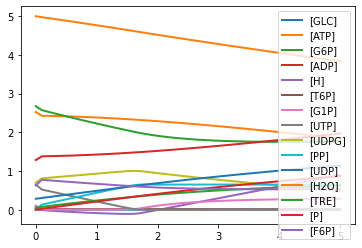

In [4]:
# GLC = glucose 
# ATP = adenosine triphosphate
# ADP = Adenosine diphosphate
# H = hydrogen ion
# UDPG = UDP-glucose
# PP = pyrophosphate/diphosphate
# P = phosphate
# TRE = tetrahalose
# G6P = glucose-6-phosphate
# G1P = glucose-1-phosphate
# UTP = uridine triphosphate
# UDP = uridine diphosphate
# T6P = tetrahalose-6-phosphate
# F6P = fructose-6-phosphate
# H20 = water

## Reaction order
# Hexokinase
# Phosphoglucomutase
# UDP–glucose phosphorylase
# T6P synthase
# T6P phosphatase
# Trehalase
# G6P isomerase

tetrahalose_MODEL_3 = """
J1: GLC + ATP -> G6P + ADP + H; Vmax1*((1/(KGLC1*KATP1))*(GLC*ATP-(G6P*ADP/Keq1)))/((1+GLC/KGLC1+G6P/KG6P1+T6P/KT6P5)*(1+ATP/KATP1+ADP/KADP1))
J2: G6P -> G1P; Vmax2*((1/KG6P2)*(G6P-G1P/Keq2))/(1+G6P/KG6P2+G1P/KG1P2)
J3: G1P + UTP + H -> UDPG + PP; Vmax3*((UTP/KUTP3)*(G1P/KG1P3))/(KiUTP3/KUTP3+UTP/KUTP3+G1P/KG1P3+(UTP*G1P/KUTP3*KG1P3)+(KiUTP3*UDPG/KUTP3*KiUDPG3)+(G1P*UDPG/KG1P3*KiUDPG3))
J4: G6P + UDPG -> T6P + UDP + H; Vmax4*(G6P*UDPG/KG6P4*KUDPG4)/((1+G6P/KG6P4)*(1+UDPG/KUDPG4))
J5: T6P + H2O -> TRE + P; Vmax5*(T6P/KT6P5)/(1+T6P/KT6P5)
J6: TRE + H2O -> GLC + GLC; Vmax6*(TRE/KTRE6)/(1+TRE/KTRE6)
J7: G6P -> F6P; Vmax7/KG6P7*(G6P-F6P/Keq7)/(1+G6P/KG6P7+F6P/KF6P7) 



KGLC1 = 0.08
KATP1 = 0.15
KG6P1 = 30
KADP1 = 0.23
KiTRH1 = 0.04
Keq1 = 2000
Vmax1 = 350
shock1 = 8

KG6P2 = 0.05
KG1P2 = 0.023
Keq2 = 1/6
Vmax2 = 0.3545
shock2 = 16 

KUTP3 = 0.11
KiUTP3 = 0.11
KG1P3 = 0.32
KiUDPG3 = 0.035
Vmax3 = 36.82
shock3 = 16

KG6P4 = 3.8
KUDPG4 = 0.886
Vmax4 = 1.371
shock4 = 12

KT6P5 = 0.5
Vmax5 = 6.5
shock5 = 18

KTRE6 = 2.99
Vmax6 = 0.5
shock6 = 6

Keq7 = 0.3  
KF6P7 = 0.29 
KG6P7 = 1.4
Vmax7 = 1071.0
shock7 = 1


ADP = 1.282
ATP = 2.525
F6P = 0.625
GLC = 0.09675
G1P = 0.1
G6P = 2.675
TRE = 0.05
T6P = 0.02
UDP = 0.2815
UDPG = 0.7
UTP = 0.6491
H2O = 5




"""
tetrahalose_MODEL_3_RR = te.loada(tetrahalose_MODEL_3)
tetrahalose_MODEL_DATA_3 = tetrahalose_MODEL_3_RR.simulate()
# plt.plot(tetrahalose_MODEL_DATA_3)
# plt.ylim([0,10])
# plt.legend()
tetrahalose_MODEL_3_RR.plot(tetrahalose_MODEL_DATA_3)

**Species Vector**

$ \begin{bmatrix}
GLC \\
ATP \\
G6P \\
ADP \\
H \\
G1P \\
UTP \\
UDPG \\
PP \\
T6P \\
UDP \\
H2O \\
TRE \\
P \\
F6P 
\end{bmatrix}  $

**Stoichiometry Vector**

$ \begin{bmatrix}
-1 & -1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & -1 & -1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 1 & 0 & 0 & -1 & 0 & 1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & -1 & 1 & 1 & 0 \\
2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}  $

The paper this model was built around discusses tetrahalose (TRE) biosynthesis in yeast. Tetrahalose is an industrially-relevant disaccharide of glucose and is produced during the heat stress response. Normally, this compound is produced when the temperature of the cell is raised above 45 C. The goal of the built controller in this model is to increase the flux of the tetrahalose pathway towards producing at least double the amount of tetrahahlose during physiological conditions (without raising the temperature to 45 C). The key reason for this is that to translate this controller to a physical system we will need to build a genetic program. At 45 C, yeast is more likely to mutate and any replicating plasmids will most likely be cured. Therefore, by raising the temperature above 37 C, we will not be able to ensure a stable genetic controller to direct the flux towards tetrahahlose biosynthesis. 

In the above tellurium simulation (please refer to the third tellurium simulation), I found that the maximum tetrahalose titer is 0.6 mM. Therefore, I am choosing the operating point to be 1.5 mM as this is more than doubling the current production titer. Producing tetrahalose removes glucose from being catabolyzed in glycolysis. To prevent any cellular fitness defects due to long-term oscillations in tetrahalose production, I am choosing the settling time to be 2.5 minutes. An additional reason for choosing the settling time to be 2.5 minutes is because there is a steady decline of our input T6P (chosen in question two). If our input levels are too low this may limit our ability to control the biosynthesis of tetrahalose as it may require a constant supply of the input. The overshoot (or a change in absolute height between the setpoint) for this settling time will be $\pm{0.1}$. The overshoot is allowed to be $\pm{0.1}$ for two reasons: to prevent the need for too much derivative control (more is explained on this later), and because double the maximum titer of tetrahalose is 1.2 mM (therefore 1.5 - 0.1 = 1.4 is still greater than our original goal of doubling the current maximum titer).



# 2. Determine the Control Input

In [5]:
def evaluateDesign(k_p, k_i, k_d):

  """
  ---Acceptable inputs: kp, ki, and kd values are floats---
  ---evaluateDesign function plots the reference input, GLC, and TRE and returns all of these values---

  """

  # Initiating the control package and building the IO system elements
  print('Start')
  ctlsb = ctl.ControlSBML(tetrahalose_MODEL_3, input_names=['T6P'], output_names=['TRE'])
  print(ctlsb)
  FACTORY = ctl.IOSystemFactory()
  controller = FACTORY.makePIDController("controller", kp=k_p, ki=k_i, kd=k_d)
  system = ctlsb.makeNonlinearIOSystem("system")
  sum_R_S = FACTORY.makeAdder("sum_R_S")
  
  # Defining connections in the closed loop feedback system
  closed_loop = control.interconnect(
  [sum_R_S, system, controller ], 
  connections=[
    ['controller.in','sum_R_S.out'],
    ['system.T6P', 'controller.out'],
    ['sum_R_S.in1', "-" + "system.TRE"]
   ],
  inplist=["sum_R_S.in2"],
  outlist = ["sum_R_S.in2", 'system.T6P', "system.TRE"]
  )

  # Simulating the step response
  X0 = ctl.makeStateVector(closed_loop)  # obtaining initial values (also available in the supplement of the paper)
  times = ctl.makeSimulationTimes(start_time=0, end_time=10, points_per_time=25)
  result = control.input_output_response(closed_loop, T=times, U=1.5, X0=X0)  # choosing U=1 based on final value of TRE after 5 minutes
  
  ## Plotting Results
  plt.figure()
  plt.plot(result.t, result.outputs[0].flatten())
  plt.plot(result.t, result.outputs[1].flatten())
  plt.plot(result.t, result.outputs[2].flatten())
  plt.ylabel('Concentration (mM)')
  plt.xlabel('Time (minutes)')
  plt.ylim([0, 20])
  legends = ["reference input", 'Tetrahalose-6-phosphate', "Tetrahalose"]
  plt.legend(legends)
  output1 = result.outputs[2]

  return result

In [6]:
## Evaluating the DC gain with different control inputs
# manually had to find all of the DC gains as they will return NaN unless I manually factor s out

# T6P
operating_time = 1
ctlsb = ctl.ControlSBML(tetrahalose_MODEL_3, input_names=['T6P'], output_names=['TRE'])
Gs = ctlsb.makeTransferFunction(time=operating_time)  # system transfer function
print('T6P Gs:',Gs)
print('T6P DC gain:',1.949E-37/2.624E-39)
print()


# GLC
ctlsb = ctl.ControlSBML(tetrahalose_MODEL_3, input_names=['GLC'], output_names=['TRE'])
Gs = ctlsb.makeTransferFunction(time=operating_time)  # system transfer function
print('GLC Gs:',Gs)
print('GLC DC gain:',-1.975E-24/1.369E-24)
print()

# G6P
ctlsb = ctl.ControlSBML(tetrahalose_MODEL_3, input_names=['G6P'], output_names=['TRE'])
Gs = ctlsb.makeTransferFunction(time=operating_time)  # system transfer function
print('G6P Gs:',Gs)
print('G6P DC gain:',1.959E-24/4.708E-24)
print()

# UDPG
ctlsb = ctl.ControlSBML(tetrahalose_MODEL_3, input_names=['UDPG'], output_names=['TRE'])
Gs = ctlsb.makeTransferFunction(time=operating_time)  # system transfer function
print('UDPG Gs:',Gs)
print('UDPG DC gain:',-3.364E-25/6.786E-25)

T6P Gs: 
   12.02 s^13 + 1.788e+04 s^12 + 7.369e+06 s^11 + 5.221e+08 s^10 + 1.28e+08 s^9 + 7.134e+06 s^8 + 1.441e-07 s^7 - 2.093e-21 s^6 - 1.949e-37 s^5
---------------------------------------------------------------------------------------------------------------------------------------------------
s^14 + 1488 s^13 + 6.133e+05 s^12 + 4.354e+07 s^11 + 1.767e+07 s^10 + 2.316e+06 s^9 + 9.602e+04 s^8 + 1.939e-09 s^7 - 2.817e-23 s^6 - 2.624e-39 s^5

T6P DC gain: 74.27591463414633

GLC Gs: 
  -1.023e-12 s^13 - 1.601e-10 s^12 + 338.7 s^11 + 2.211e+05 s^10 + 1.693e+07 s^9 + 2.551e+06 s^8 + 3.496e-07 s^7 - 3.198e-10 s^6 - 1.975e-24 s^5
--------------------------------------------------------------------------------------------------------------------------------------------------
s^14 + 845.2 s^13 + 1.052e+05 s^12 + 3.75e+06 s^11 + 3.257e+07 s^10 + 1.275e+07 s^9 + 1.637e+06 s^8 + 6.644e+04 s^7 + 7.42e-10 s^6 + 1.369e-24 s^5

GLC DC gain: -1.4426588750913076

G6P Gs: 
    9.095e-13 s^13 + 0.517

From these DC gains, we can see that at steady state a step input of T6P will result in a huge increase in the output TRE. This is in no way surprising considering T6P is a reactant in the reaction directly synthesizing TRE. Both UDPG and GLC are inversely related to the production of tetrahalose and would need a significant step input for there to be a positive production. For reference the DC gain for each of the inputs towards producing TRE is as follows (shown in the above code as well):

T6P: 74

GLC: -1.44

G6P: 0.42

UDPG: -0.50

Therefore, the two reasonable candidates are G6P and T6P. However, controlling the production of TRE with G6P also presents an additional challenge as it is involved in many of the reactions. Attempting to control with G6P or UDPG present long loading times when attempting to control TRE with a PID controller without noise or disturbances. 

**Therefore, I unfortunately had to choose the simplest option in this case which is to control the biosynthesis of TRE with T6P**

# 3. Design the Control System

Start


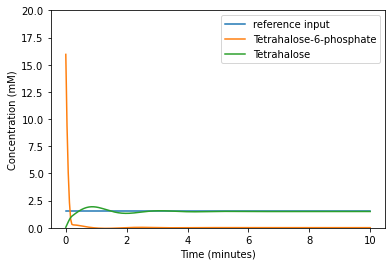

In [7]:
result = evaluateDesign(1,1,1)

Start


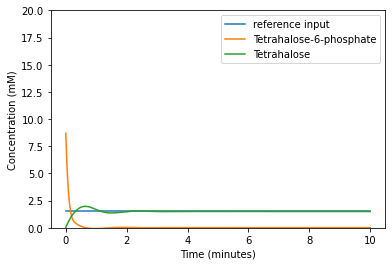

In [8]:
result = evaluateDesign(1,1,0.5)

Start


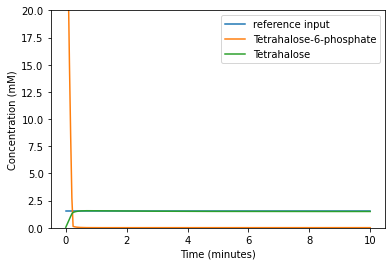

In [9]:
result = evaluateDesign(20,1,1)

In [10]:
operating_time = 1
kp = 20
ki = 1
kd = 1
ctlsb = ctl.ControlSBML(tetrahalose_MODEL_3, input_names=['T6P'], output_names=['TRE'])
Gs = ctlsb.makeTransferFunction(time=operating_time)  # system transfer function
print('Transfer function for Tetrahalose (Gs):', Gs)
print('T6P Gs:',Gs)
print('T6P DC gain:',1.949E-37/2.624E-39)
print()
Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0]) + control.TransferFunction([kd, 0], [1]) # controller transfer function
print('Controller Transfer Function:',Cs)
print()

HRY = (Gs*Cs)/(1+Gs*Cs)  # Transfer function between input and output
print('HRY Transfer Function:', HRY)
print('Poles of transfer function between the input and output:')
print(HRY.pole())
print()
print('The poles tell us this system is stable and oscillates around the setpoint')
print('Overall closed-loop DC gain:',5.11E-76/5.11E-76)

Transfer function for Tetrahalose (Gs): 
   12.02 s^13 + 1.788e+04 s^12 + 7.369e+06 s^11 + 5.221e+08 s^10 + 1.28e+08 s^9 + 7.134e+06 s^8 + 1.441e-07 s^7 - 2.093e-21 s^6 - 1.949e-37 s^5
---------------------------------------------------------------------------------------------------------------------------------------------------
s^14 + 1488 s^13 + 6.133e+05 s^12 + 4.354e+07 s^11 + 1.767e+07 s^10 + 2.316e+06 s^9 + 9.602e+04 s^8 + 1.939e-09 s^7 - 2.817e-23 s^6 - 2.624e-39 s^5

T6P Gs: 
   12.02 s^13 + 1.788e+04 s^12 + 7.369e+06 s^11 + 5.221e+08 s^10 + 1.28e+08 s^9 + 7.134e+06 s^8 + 1.441e-07 s^7 - 2.093e-21 s^6 - 1.949e-37 s^5
---------------------------------------------------------------------------------------------------------------------------------------------------
s^14 + 1488 s^13 + 6.133e+05 s^12 + 4.354e+07 s^11 + 1.767e+07 s^10 + 2.316e+06 s^9 + 9.602e+04 s^8 + 1.939e-09 s^7 - 2.817e-23 s^6 - 2.624e-39 s^5

T6P DC gain: 74.27591463414633

Controller Transfer Function: 
s^2 +

For the purpose of finding out if our system under control with the PID controller, it is necessary to view the poles and the DC gain of the overall transfer function describing the relationship between the input and output of the complete closed-loop feedback system. From the above code I printed the system transfer function ${G_s}$ and the overall transfer function ${H_{RY}}$. From these transfer functions, I can calculate the DC gains. Previously, I had calculated the DC gain for ${G_s}$ with T6P and found that unsurprisingly that any changes in input have huge positive affects on the output as the DC gain is 74. 

From the poles of the overall transfer function, it is clear that my system is stable (all poles are negative or 0) and oscillatory (presence of complex poles). 

Therefore, with these sustained oscillations, to control this system I will need derivative control to dampen the oscillations and a large proportional control to get the output closer to the desired setpoint. I will need a large proportional control in this case because of how large the DC gain is, it will most likely be very easy initially to overshoot the desired output. 

As I will need at the very least both proportional and integral control, **I have decided to use a PID controller to control the flux of tetrahalose**. 

# 4. Evaluate the Design

**System Equations**



In [11]:
def evaluateDesignDisturbanceNoise(k_p, k_i, k_d):

  """
  ---Acceptable inputs: kp, ki, and kd values are floats---
  ---evaluateDesign function plots the reference input, GLC, and TRE and returns all of these values---

  """

  # Initiating the control package and building the IO system elements
  ctlsb = ctl.ControlSBML(tetrahalose_MODEL_3, input_names=['T6P'], output_names=['TRE'])
  print('this function')
  FACTORY = ctl.IOSystemFactory()
  controller = FACTORY.makePIDController("controller", kp=k_p, ki=k_i, kd=k_d)
  system = ctlsb.makeNonlinearIOSystem("system")
  fltr = FACTORY.makeFilter("fltr", -1)
  neg_fltr = FACTORY.makeMultiplier("neg_fltr", -1)
  sum_R_NF = FACTORY.makeAdder("sum_R_NF")
  sum_U_D = FACTORY.makeAdder("sum_U_D")
  sum_N_Y = FACTORY.makeAdder("sum_N_Y")
  noise = FACTORY.makeSinusoid("noise", 1, 5)
  disturbance = FACTORY.makeSinusoid("disturbance",0,5)
  
  # Defining connections in the closed loop feedback system
  closed_loop = control.interconnect(
  [sum_N_Y, system, controller, noise, disturbance, sum_R_NF, sum_U_D, fltr, neg_fltr], 
  connections=[
    ['controller.in','sum_R_NF.out'],
    ['sum_R_NF.in1','neg_fltr.out'],
    ['sum_U_D.in1','controller.out'],
    ['sum_U_D.in2','disturbance.out'],
    ['system.T6P', 'sum_U_D.out'],
    ['sum_N_Y.in1', "system.TRE"],
    ['sum_N_Y.in2', 'noise.out'],
    ['fltr.in','sum_N_Y.out'],
    ['neg_fltr.in', 'fltr.out']
   ],
  inplist=["sum_R_NF.in2"],
  outlist = ["sum_R_NF.in2", 'system.T6P', "system.TRE","sum_N_Y.out"]
  )


  # Simulating the step response
  X0 = ctl.makeStateVector(closed_loop)  # obtaining initial values (also available in the supplement of the paper)
  times = ctl.makeSimulationTimes(start_time=0, end_time=20, points_per_time=25)
  result = control.input_output_response(closed_loop, T=times, U=1.5, X0=X0)  # choosing U=1.5 based on final value of TRE after 5 minutes
  
  ## Plotting Results
  plt.figure()
  plt.plot(result.t, result.outputs[0].flatten())
  plt.plot(result.t, result.outputs[1].flatten())
  plt.plot(result.t, result.outputs[2].flatten())
  plt.plot(result.t, result.outputs[3].flatten())
  plt.ylabel('Concentration (mM)')
  plt.xlabel('Time (minutes)')
  plt.ylim([0, 20])
  legends = ["reference input", 'Tetrahalose-6-phosphate', "Tetrahalose", 'Output']
  plt.legend(legends)
  
  # Finding the index at 2.5 minutes
  tetrahalose_output = result.outputs[3]
  tetrahalose_output = np.array(tetrahalose_output)
  sim_time = np.array(result.t)
  settling_time_index = np.where(sim_time==2.52)
  
  
  # Tests for an Overshoot of <0.1
  overshoot = 1.5 - tetrahalose_output[settling_time_index]
  print('Overshoot:',overshoot)
  if abs(overshoot)<0.01:
    print('Overshoot is less than 0.1')
  


  return result

this function
Overshoot: [-0.16372785]


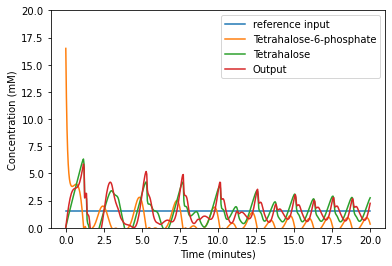

In [12]:
result = evaluateDesignDisturbanceNoise(1,1,1)

this function
Overshoot: [-0.07342588]


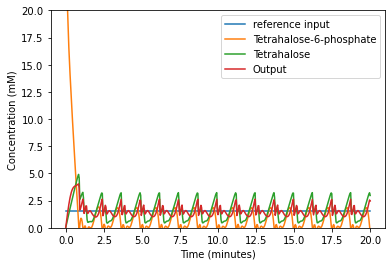

In [13]:
result = evaluateDesignDisturbanceNoise(10,1,1)

In [ ]:
result = evaluateDesignDisturbanceNoise(20,1,1)

this function


In [ ]:
result=evaluateDesignDisturbanceNoise(20,1,2)

In [ ]:
result=evaluateDesignDisturbanceNoise(20,0.4,1)

In [ ]:
result=evaluateDesignDisturbanceNoise(20,0.4,2)

In [ ]:
result=evaluateDesignDisturbanceNoise(20,0.4,4)

In [ ]:
result=evaluateDesignDisturbanceNoise(20,0.4,6)

In [ ]:
result=evaluateDesignDisturbanceNoise(20,0.4,6.5)

To construct my SBML model, in addition to a controller, I added sinusoidal inputs for both a disturbance and noise. For the disturbance, I chose an amplitude of 0 and a frequency of 5. For the noise, I chose an amplitude of 1 and a frequency of 5. These are the highest disturbance amplitudes and frquencies that I was able to control within a reasonable amount of time (as dictated by the settling time and offshoot discussed in question 1). For my filter, I used a simple proportional filter model as described in the CtlSMBL package. 

As previously predicted, a large increase in proportional control brought the output (tetrahalose) much closer to the chosen setpoint of 1.5 mM. However, with proportional control alone, there were still huge osccilations. My proposed solution to this was derivative control as a means of dampening the oscillations. This strategy works and doubling the amount of proportional control drastically decreases oscillations. Integral control can sometimes cause oscillations in non-oscillatory systems as it calculates the error area which is a function of time. To fix any potential further compounding oscillations, the integral control was lowered. The last iterations of the controller were to just further dampen the oscillations by steadily increasing the integral control without letting the system become unstable. From this analysis I determined the control parameters to be:

${k_p}=20$

${k_i}=0.4$

${k_d}=6$

These parameters where able to satisfy the overshoot condition (.09 overshoot in this case) and settle within 2.5 minutes at the desired setpoint of 1.5 mM. 

# 5. Discuss Trade-offs

**General Tradeoffs**

There were many tradeoffs in the construction of this closed loop control of tetrahalose production. The first is that I was unable to incorporate glucose transport through the media. In large scale bioreactor systems, transport coefficients are determined usually for both substrates (glucose in this case) and dissolved oxygen transport to the surface of the cellular membrane. Although the paper gave information about the glucose transfer rate from the glucose rich media to the intracellular lumen, I was unable to control the system even without the addition of a disturbance or noise. Another tradeoff was the choice for the input of my system. Ideally, I would want to choose an input that is relevant to real-life engineering. Therefore, the ideal choice would be to choose glucose as an input as this is easily varied in the media. However, many of the enzymes in my biosynthetic pathway are competitively inhibited by glucose (which is portrayed in the kinetics in the tellurium model). This is to be expected as yeast are only naturally programmed to produce tetrahalose under high temperature stress conditions and the pathway should be inhibited under basal conditions. Additionally, there is already a biological feedback system in place to produce additional glucose in this pathway. Both of these factors make the production of tetrahalose extremely difficult to control when varying glucose. Several other inputs were attempted such as G6P and UDPG, but both either could not control production or had extremely long loading times without the addition of disturbance or noise to the closed loop system. Another tradeoff that could affect whether this controller could be implemented physiologically is that this system is extremely sensitive to the amplitude and frequency of the noise and disturbance implemented. If implementing a genetic program to control tetrahalose production causes a large disturbance or if there's extensive variability between your cell population in the form of intrinsic and extrinsic noise, then this controller design would not be feasible to maintain a steady state biosynthesis of tetrahalose. 

**Parameter Tradeoffs**

For this controller, I needed to have large proportional and derivative control and small integral control. These parameter choices pose a few issues. This high derivative control is the highest allowable value for derivative control. Without a subsequent increase in proportional and integral control, high derivative control parameters lead to a destablized closed loop system. If rather than a genetic controller, we were using a physical TRE sensor, then this high derivative controller would cause the deterioration of our equipment much faster. This is because a high derivative control causes changes for small changes in error. Ultimately for this simulation the high derivative control was necessary to dampen oscillations, but if this controller was being built in real life an engineer may opt for less derivative control to ensure longer equipment lifetimes. One issue with using too high of a proportional control variable is that it leads to oscillations. So although the large proportional control enabled the output to approach the setpoint, it contributed to the sustained oscillations. The reason that the high derivative control needed to be supplemented with the high proportional control because as the output approaches the setpoint, a large proportional control will have a lesser effect. Therefore, in a real-life scenario an engineer may opt for a larger overshoot. This would mean they could effectively increase the amount of proportional and derivative control and ensure stability and not increase the amount of sustained oscillations present in the system. 